# Observe model variables

In [ ]:
from pprint import pprint

import matplotlib.pyplot as plt
import torch

from dataset.lenet_cifar import LeNet, make_testloader
from mrfi import MRFI, EasyConfig
from mrfi.experiment import get_activation_info, get_weight_info

Load MRFI model with empty config for observe.

In [2]:
fi_model = MRFI(LeNet(trained=True).eval(), EasyConfig())
print(fi_model, fi_model.model)

<mrfi.mrfi.MRFI object at 0x000001CE42E4F040> Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


Then make cifar10 testloader, verify input shape

In [3]:
input_images = make_testloader(128, batch_size = 128)
imgs, labels = next(iter(input_images))
print(imgs[0].shape, 'label:', labels[0])

torch.Size([3, 32, 32]) label: tensor(3)


Firstly, lets observe feature map shape by simply call `get_activation_info` with `method = Shape`!
Also, we can observe weights in same way. `get_weight_info` does not require inference.
Observer methods are defined in mrfi.observer, you can also add custom observer by `mrfi.add_function`

In [4]:
print("Activation Shape:")
pprint(get_activation_info(fi_model, torch.zeros([1,3,32,32]), 'Shape'))
pprint("Weight Shape:")
pprint(get_weight_info(fi_model, 'Shape'))

Activation Shape:
{'model.Shape': torch.Size([1, 10]),
 'model.conv1.Shape': torch.Size([1, 6, 28, 28]),
 'model.conv2.Shape': torch.Size([1, 16, 10, 10]),
 'model.fc1.Shape': torch.Size([1, 120]),
 'model.fc2.Shape': torch.Size([1, 84]),
 'model.fc3.Shape': torch.Size([1, 10])}
'Weight Shape:'
{'conv1.weight': torch.Size([6, 3, 5, 5]),
 'conv2.weight': torch.Size([16, 6, 5, 5]),
 'fc1.weight': torch.Size([120, 400]),
 'fc2.weight': torch.Size([84, 120]),
 'fc3.weight': torch.Size([10, 84])}


Then, we can observe min/max ranges of values, this is very useful to make a quantization model.

In [5]:
print("Activation MinMax:")
pprint(get_activation_info(fi_model, input_images))
print("Weight MinMax:")
pprint(get_weight_info(fi_model))

Activation MinMax:
{'model.MinMax': (-10.844356536865234, 8.558104515075684),
 'model.conv1.MinMax': (-5.00702428817749, 5.420466423034668),
 'model.conv2.MinMax': (-9.770880699157715, 6.261801242828369),
 'model.fc1.MinMax': (-13.205606460571289, 9.709344863891602),
 'model.fc2.MinMax': (-8.901363372802734, 8.150411605834961),
 'model.fc3.MinMax': (-10.844356536865234, 8.558104515075684)}
Weight MinMax:
{'conv1.weight': (-0.3178213834762573, 0.3564322888851166),
 'conv2.weight': (-0.3756081163883209, 0.32203108072280884),
 'fc1.weight': (-0.6651991009712219, 0.4576374590396881),
 'fc2.weight': (-0.4559188485145569, 0.33350828289985657),
 'fc3.weight': (-0.44256511330604553, 0.4379429221153259)}


`MaxAbs` is a similiar observer.
We can filter modules by optional argument `module_name`, `module_type` or `module_fullname`.

In [19]:
print("Activation MaxAbs:")
pprint(get_activation_info(fi_model, input_images, 'MaxAbs', module_name = ['conv']))
print("Weight MaxAbs:")
pprint(get_weight_info(fi_model, 'MaxAbs', module_type = ['Linear']))

Activation MaxAbs:
{'model.conv1.MaxAbs': 5.420466423034668,
 'model.conv2.MaxAbs': 9.770880699157715}
Weight MaxAbs:
{'fc1.weight': 0.6651991009712219,
 'fc2.weight': 0.4559188485145569,
 'fc3.weight': 0.44256511330604553}


To obtain how divergent the distribution of variables is, let's
observe standard deviation of variable by `Std` observer.

In [7]:
print("Activation Std:")
pprint(get_activation_info(fi_model, input_images, 'Std'))
print("Weight Std:")
pprint(get_weight_info(fi_model, 'Std'))

Activation Std:
{'model.Std': 3.0110209209484347,
 'model.conv1.Std': 0.6536869451555304,
 'model.conv2.Std': 0.960684580199324,
 'model.fc1.Std': 2.5316612945593397,
 'model.fc2.Std': 1.8289168509494267,
 'model.fc3.Std': 3.0110209209484347}
Weight Std:
{'conv1.weight': 0.12276468009677341,
 'conv2.weight': 0.10105224038704899,
 'fc1.weight': 0.07574824678816457,
 'fc2.weight': 0.08999676217606199,
 'fc3.weight': 0.13330479151244343}


Next, let's simply draw variable distribution figure by `UniformSampling` observer!
This method defaults to uniformly sampling up to 10000 data points, 
so you don't have to worry about memory overflow due to too large tensors.

{'bodies': [<matplotlib.collections.PolyCollection at 0x1ce7362ef10>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1ce7362ee50>,
 'cmins': <matplotlib.collections.LineCollection at 0x1ce7373a220>,
 'cbars': <matplotlib.collections.LineCollection at 0x1ce7373a640>}

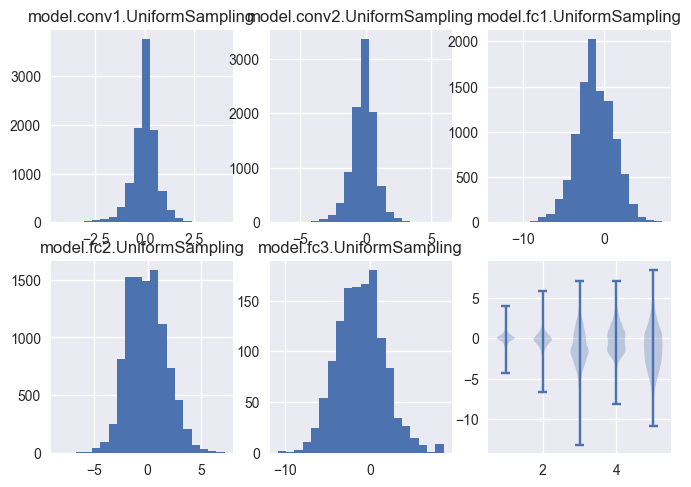

In [9]:
act_samping = get_activation_info(fi_model, input_images, 'UniformSampling', module_name = ['conv', 'fc'])
fig, axs = plt.subplots(2,3)
for i, (name, value) in enumerate(act_samping.items()):
    ax = axs[i//3, i%3]
    ax.hist(value, bins=20)
    ax.set_title(name)
axs[1,2].violinplot(list(act_samping.values()))

Draw weights distribution by same way.

{'bodies': [<matplotlib.collections.PolyCollection at 0x1ce73857d30>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x1ce73857d60>,
 'cmins': <matplotlib.collections.LineCollection at 0x1ce73bc0220>,
 'cbars': <matplotlib.collections.LineCollection at 0x1ce73bc0640>}

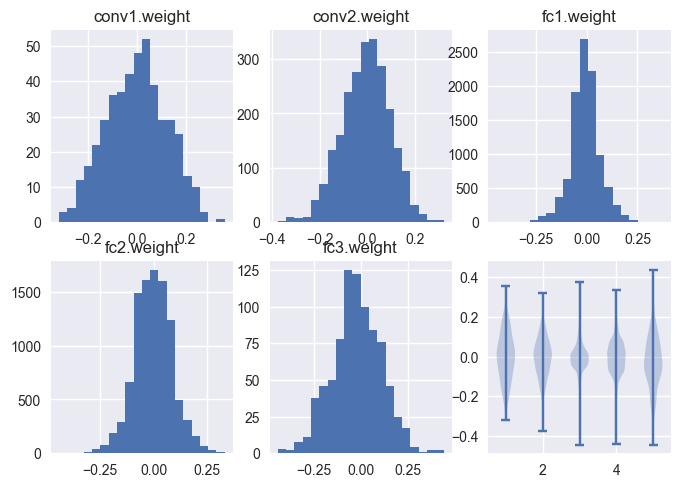

In [10]:
weight_samping = get_weight_info(fi_model, 'UniformSampling')
fig, axs = plt.subplots(2,3)
for i, (name, value) in enumerate(weight_samping.items()):
    ax = axs[i//3, i%3]
    ax.hist(value, bins=20)
    ax.set_title(name)
axs[1,2].violinplot(list(weight_samping.values()))

Finally, let's visualize featuremap by simple by `SaveLast` method.
This observer saves inference variable,
So we expect get featuremap size (batch_size = 128, channels = 6, height = 28, width = 28) of LeNet conv1 output.

In [11]:
last_featuremap = get_activation_info(fi_model, input_images, 'SaveLast', module_name = ['conv1'])
print(last_featuremap.keys())

dict_keys(['model.conv1.SaveLast'])


In [12]:
featuremap = last_featuremap['model.conv1.SaveLast'][1].numpy()
print(featuremap.shape)

(128, 6, 28, 28)


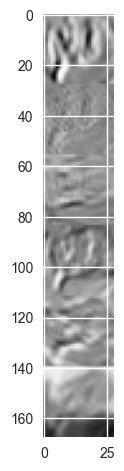

In [13]:
plt.imshow(featuremap[0].reshape(-1, 28))

Done! We have made common observations on the model, is it simple and clear enough? :)

Another type of observer, including `RMSE`/`MAE`/`EqualRate` ,can compare the impact of fault injections. They needs to be used in conjunction with the fault injector.